In [1]:
# Imports:

    #astropy imports
import astropy.coordinates as coord
from astropy.table import QTable
import astropy.units as u
from astroquery.gaia import Gaia

    #Third-party imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

    #gala imports
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

In [47]:
# GAIA query for data importing:
query_text = '''SELECT TOP 4096 ra, dec, parallax, pmra, pmdec, radial_velocity,
phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag
FROM gaiadr2.gaia_source
WHERE parallax_over_error > 10 AND
    parallax > 10 AND
    radial_velocity IS NOT null
ORDER BY random_index
'''
gaia_data = QTable.read('gaia_data.fits')


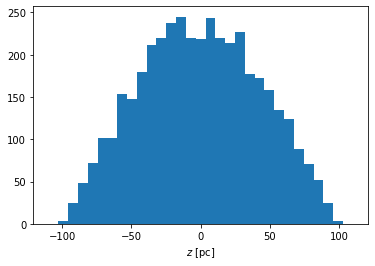

In [49]:
# Data checking:
gaia_data[:4]

dist = coord.Distance(parallax=u.Quantity(gaia_data['parallax']))
dist.min(), dist.max()

c = coord.SkyCoord(ra=gaia_data['ra'], 
                   dec=gaia_data['dec'],
                   distance=dist,
                   pm_ra_cosdec=gaia_data['pmra'], 
                   pm_dec=gaia_data['pmdec'],
                   radial_velocity=gaia_data['radial_velocity'])
c[:4]

c.galactic[:4]

coord.Galactocentric()
galcen = c.transform_to(coord.Galactocentric(z_sun=0*u.pc,galcen_distance=8.1*u.kpc))
galcen[:4]
plt.hist(galcen.z.value, bins=np.linspace(-110, 110, 32))
plt.xlabel('$z$ [{0:latex_inline}]'.format(galcen.z.unit));

593
185


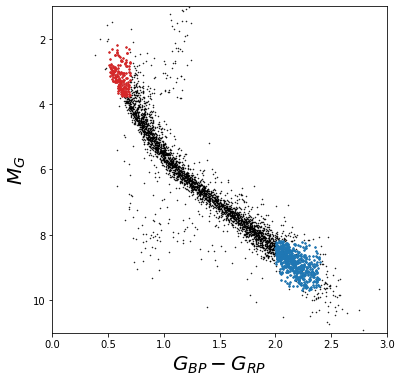

In [50]:
#CMD diagram
np.seterr(invalid="ignore")
hi_mass_mask = ((BP_RP > 0.5*u.mag) & (BP_RP < 0.7*u.mag) & 
                (M_G > 2*u.mag) & (M_G < 3.75*u.mag) & 
                (np.abs(galcen.v_y - 220*u.km/u.s) < 50*u.km/u.s))

lo_mass_mask = ((BP_RP > 2*u.mag) & (BP_RP < 2.4*u.mag) & 
                (M_G > 8.2*u.mag) & (M_G < 9.7*u.mag) &
                (np.abs(galcen.v_y - 220*u.km/u.s) < 50*u.km/u.s))


hi_mass_color = 'tab:red'
lo_mass_color = 'tab:blue'

fig = plt.figure(figsize=(6,6))

plt.plot(BP_RP.value, M_G.value,'k.',ms=1)

for mask, color in zip([lo_mass_mask, hi_mass_mask],
                       [lo_mass_color, hi_mass_color]):
    plt.plot(BP_RP[mask].value, M_G[mask].value,'.',ms=3, color=color)
    print(len(BP_RP[mask]))
plt.xlim(0, 3)
plt.ylim(11, 1)
plt.xlabel('$G_{BP}-G_{RP}$',fontsize=20)
plt.ylabel('$M_G$',fontsize=20)
plt.savefig('figures/HR_stars.png',bbox_inches='tight',dpi=300)

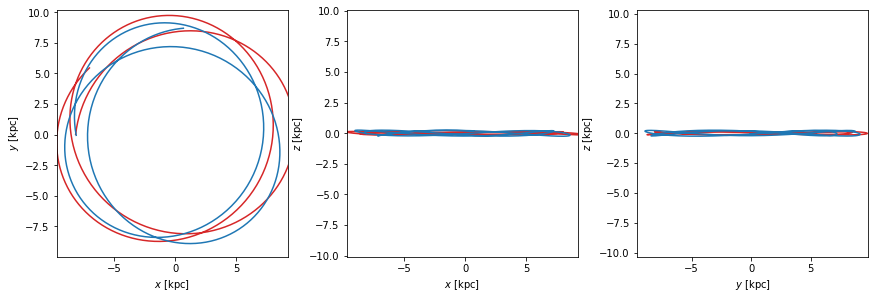

In [85]:
# Orbit integration t=500:
milky_way = gp.MilkyWayPotential()
different_disk_potential = gp.MilkyWayPotential(disk=dict(m=8e10*u.Msun))
H = gp.Hamiltonian(milky_way)
w0_hi = gd.PhaseSpacePosition(galcen[hi_mass_mask].cartesian)
w0_lo = gd.PhaseSpacePosition(galcen[lo_mass_mask].cartesian)

orbits_hi = H.integrate_orbit(w0_hi, dt=1*u.Myr, 
                              t1=0*u.Myr, t2=500*u.Myr)

orbits_lo = H.integrate_orbit(w0_lo, dt=1*u.Myr, 
                              t1=0*u.Myr, t2=500*u.Myr)

fig = orbits_hi[:, 0].plot(color=hi_mass_color)
_ = orbits_lo[:, 0].plot(axes=fig.axes, color=lo_mass_color)
plt.savefig('figures/orbits_500.png',bbox_inches='tight',dpi=300)

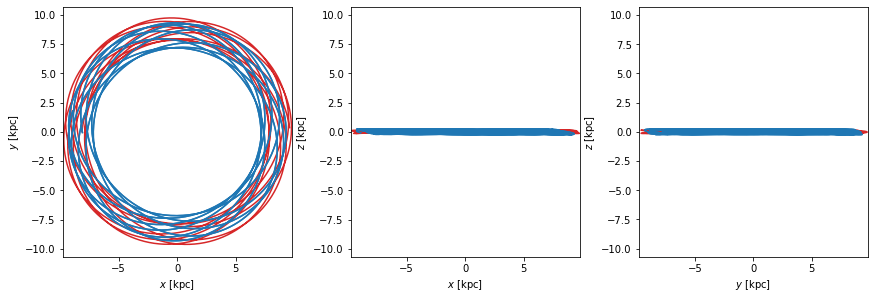

In [125]:
# Orbit integration t=2000:
orbits_hi = H.integrate_orbit(w0_hi, dt=1*u.Myr, 
                              t1=0*u.Myr, t2=2000*u.Myr)
fig = orbits_hi[:, 0].plot(color=hi_mass_color)

orbits_lo = H.integrate_orbit(w0_lo, dt=1*u.Myr, 
                              t1=0*u.Myr, t2=2000*u.Myr)
fig = orbits_lo[:, 0].plot(axes=fig.axes, color=lo_mass_color)
_ = orbits_lo[:, 0].plot(axes=fig.axes, color=lo_mass_color)
plt.savefig('figures/orbits_2000.png',bbox_inches='tight',dpi=300)

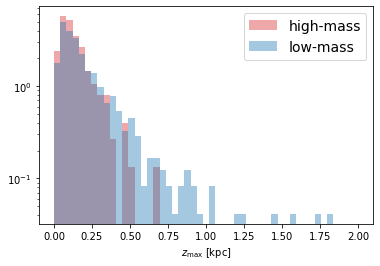

In [103]:
# Zmax histogram:
zmax_hi = orbits_hi.zmax(approximate=True)
zmax_lo = orbits_lo.zmax(approximate=True)

bins = np.linspace(0, 2, 50)

plt.hist(zmax_hi.value, bins=bins, 
         alpha=0.4, density=True, label='high-mass', 
         color=hi_mass_color)
plt.hist(zmax_lo.value, bins=bins, 
         alpha=0.4, density=True, label='low-mass',
         color=lo_mass_color);

plt.legend(loc='best', fontsize=14)

plt.yscale('log')
plt.xlabel(r"$z_{\rm max}$" + " [{0:latex}]".format(zmax_hi.unit))
plt.savefig('figures/hist_z.png',bbox_inches='tight',dpi=300)

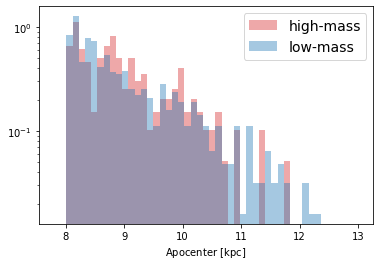

In [102]:
# Apocenter histogram:
apo_hi = orbits_hi.apocenter(approximate=True)
apo_lo = orbits_lo.apocenter(approximate=True)

bins = np.linspace(7.8, 13, 50)

plt.hist(apo_hi.value, bins=bins, 
         alpha=0.4, density=True, label='high-mass', 
         color=hi_mass_color)
plt.hist(apo_lo.value, bins=bins, 
         alpha=0.4, density=True, label='low-mass',
         color=lo_mass_color);

plt.legend(loc='best', fontsize=14)

plt.yscale('log')
plt.xlabel(r"Apocenter" + " [{0:latex}]".format(apo_hi.unit))
plt.savefig('figures/hist_apo.png',bbox_inches='tight',dpi=300)

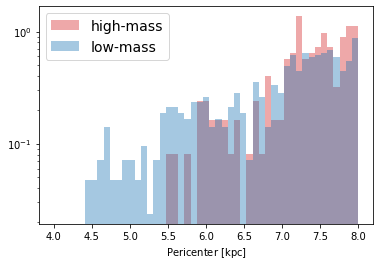

In [108]:
# Pericenter histogram:
peri_hi = orbits_hi.pericenter(approximate=True)
peri_lo = orbits_lo.pericenter(approximate=True)

bins = np.linspace(4, 8, 50)

plt.hist(peri_hi.value, bins=bins, 
         alpha=0.4, density=True, label='high-mass', 
         color=hi_mass_color)
plt.hist(peri_lo.value, bins=bins, 
         alpha=0.4, density=True, label='low-mass',
         color=lo_mass_color);

plt.legend(loc='best', fontsize=14)

plt.yscale('log')
plt.xlabel(r"Pericenter" + " [{0:latex}]".format(peri_hi.unit))
plt.savefig('figures/hist_peri.png',bbox_inches='tight',dpi=300)

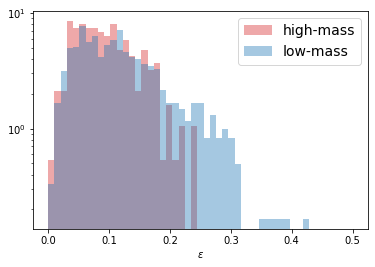

In [107]:
# Eccentricity histogram:
ecc_hi = orbits_hi.eccentricity(approximate=True)
ecc_lo = orbits_lo.eccentricity(approximate=True)

bins = np.linspace(0, 0.5, 50)

plt.hist(ecc_hi.value, bins=bins, 
         alpha=0.4, density=True, label='high-mass', 
         color=hi_mass_color)
plt.hist(ecc_lo.value, bins=bins, 
         alpha=0.4, density=True, label='low-mass',
         color=lo_mass_color);

plt.legend(loc='best', fontsize=14)

plt.yscale('log')
plt.xlabel(r"$\epsilon$".format(ecc_hi.unit))
plt.savefig('figures/hist_ecc.png',bbox_inches='tight',dpi=300)

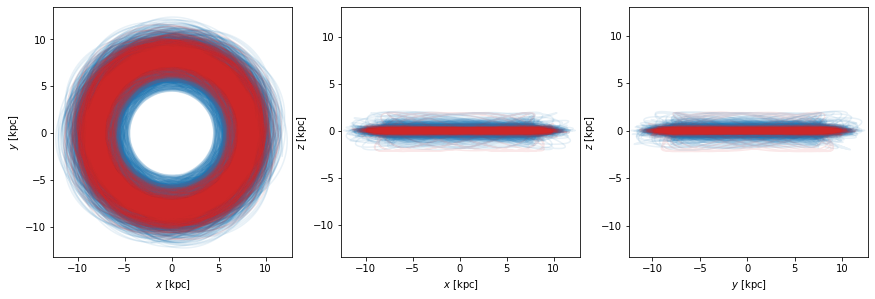

In [127]:
# Orbit integration t=2000 for all trajectories:
orbits_lo = H.integrate_orbit(w0_lo, dt=1*u.Myr, 
                              t1=0*u.Myr, t2=2000*u.Myr)
fig = orbits_lo[:,:].plot(color=lo_mass_color,alpha=0.1)
orbits_hi = H.integrate_orbit(w0_hi, dt=1*u.Myr, 
                              t1=0*u.Myr, t2=2000*u.Myr)
fig = orbits_hi[:,:].plot(color=hi_mass_color,axes=fig.axes,alpha=0.1)
plt.savefig('figures/orbits_2000_all.png',bbox_inches='tight',dpi=300)